In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [40]:
# importing relevant libraries

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import cv2
from PIL import Image
from tensorflow import keras
from skimage import io
from sklearn.preprocessing import MultiLabelBinarizer

In [41]:
# loading the csv metadata files

train_classes = pd.read_csv("../input/planets-dataset/planet/planet/train_classes.csv")
sample_sub = pd.read_csv("../input/planets-dataset/planet/planet/sample_submission.csv")
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
# dict for converting labels to numerical classes

label_map = {'agriculture': 14,
 'artisinal_mine': 5,
 'bare_ground': 1,
 'blooming': 3,
 'blow_down': 0,
 'clear': 10,
 'cloudy': 16,
 'conventional_mine': 2,
 'cultivation': 4,
 'habitation': 9,
 'haze': 6,
 'partly_cloudy': 13,
 'primary': 7,
 'road': 11,
 'selective_logging': 12,
 'slash_burn': 8,
 'water': 15}

In [ ]:
# Loading the training images

#x_train, y_train = [], []

#for img_name, tags in tqdm(train_classes.values, miniters=1000):
    #arr = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(img_name))
    #targets = np.zeros(17)
    #for t in tags.split(' '):
   #     targets[label_map[t]] = 1 
  #  x_train.append(cv2.resize(arr, (64, 64)))
 #   y_train.append(targets)

# normalizing train image pixels
#y_train = np.array(y_train, np.uint8)
#x_train = np.array(x_train,np.float16)/255.0

In [ ]:
# numbers of tags and their names
counts = {}
splitted_tags = train_classes['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values());

In [ ]:
len(splitted_tags)

In [ ]:
#load data
all_labels = splitted_tags.values
labels = list(set([y for x in all_labels for y in x]))

def load_data(train_classes, labels, resize):
    x_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in train_classes.values:
        img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f)) 
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        x_train.append(cv2.resize(img,resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    x_train = np.array(x_train, np.float16) / 255.

    return x_train, y_train

In [ ]:
import gc
gc.collect()

In [ ]:
x, y = load_data(train_classes, labels, resize=(64, 64))

In [ ]:
gc.collect()

In [ ]:
print(x.shape)
print(y.shape)

In [ ]:
# checking the images of the datasets

print(train_classes.shape)
print(sample_sub.shape)

In [ ]:
from sklearn.model_selection import train_test_split

import time

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state = int(time.time()))

In [ ]:
print(y_train.shape)
print(x_train.shape)
print(x_val.shape)
print(y_val.shape)

In [ ]:
# making use of the training set


#img='train_10016.jpg'
#path = '../input/planets-dataset/planet/planet/train-jpg/{}'.format(img)

#plt.imshow(io.imread(path))

#

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)



path = Path('/kaggle/input/planets-dataset/planet/planet')
path.ls()

In [ ]:
np.random.seed(42)
src = (ImageList.from_csv(path,'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))


data = (src.transform(tfms, size=128)
        .databunch(num_workers=0).normalize(imagenet_stats))

data.show_batch(rows=3, figsize=(12,9))

In [ ]:
# Since this is a multi lable task and the labels are given as tags in a single dataframe series

biner = MultiLabelBinarizer()
tags = train_classes['tags'].str.split()
y = biner.fit_transform(tags)

labels = biner.classes_
print('Number of labels: ', len(labels))
print('\n')
print(labels)

In [ ]:
# Getting the labels into one hot encoded form for EDA ease. 

#for label in labels:
    #train_classes[label] = train_classes['tags'].apply(lambda x: 1 if label in x.split()  else 0)
    
#train_classes.head()

In [ ]:
#train_classes[labels].sum().sort_values(ascending=False).plot(kind='barh', figsize=(8,8))

# **Learning curve**

In [ ]:


def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()



# **F beta score - metric**

In [ ]:


def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result



In [ ]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam

In [ ]:
gc.collect()

# **Using V G G**

In [ ]:
optimizer = Adam(0.003, decay=0.0005)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False
    
    model = Sequential([
    base_model,
 
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')  
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

In [ ]:
model_fit = model.fit( x_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(x_val, y_val))

In [ ]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

In [ ]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [ ]:
gc.collect()

In [ ]:
# decrease learning step and decay

optimizer = Adam(0.0001, decay=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])

model_fit = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val))

In [ ]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

In [ ]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [ ]:
gc.collect()

In [ ]:
# adding more layer to learn

for layer in model.layers[0].layers[1:]:
    layer.trainable = True

for layer in model.layers[0].layers:
    print(layer.name, layer. trainable)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

In [ ]:
model_fit = model.fit(
    x, y,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val))

In [42]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100-score*100))

F beta score:  0.9565857861156384
Error: 4.34%


In [53]:
gc.collect()

2770

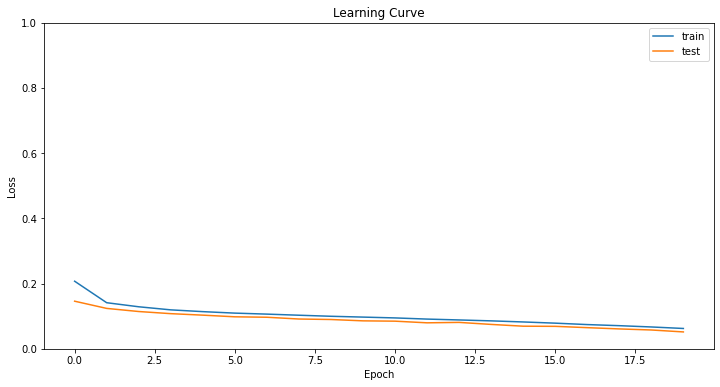

In [54]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [ ]:
# I will check fit_generator for my the best solution

aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")
 
model_fit = model.fit_generator(aug.flow(x, y, batch_size=64),
                        validation_data=(x_val, y_val), steps_per_epoch=len(x) // 128,
                        epochs=5)

In [ ]:
y_pred = model.predict(x_val, batch_size=64)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100-score*100))

In [ ]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [ ]:
# now to check the Test data


X_test=[]

for img, label in tqdm(sample_sub[:40669].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img)), (64,64)))

for img, label in tqdm(sample_sub[40669:].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64,64)))

x_test = np.array(X_test, np.float16)/255

In [ ]:
x_test.shape

In [45]:
Test_Predictions = model.predict(x_test, batch_size = 64)

In [47]:
Test_Predictions


array([[3.2794054e-03, 3.8370413e-03, 2.6871741e-04, ..., 4.4129868e-03,
        9.9943000e-01, 3.9155774e-02],
       [8.9911884e-03, 1.4032130e-03, 1.3339215e-04, ..., 5.9014261e-02,
        9.9989867e-01, 1.8339401e-01],
       [1.7899765e-05, 8.0907915e-04, 2.2235048e-05, ..., 2.3644958e-05,
        1.2609460e-05, 4.4908804e-05],
       ...,
       [2.6242344e-05, 1.3204773e-02, 1.8016238e-03, ..., 4.2056639e-04,
        9.9985671e-01, 3.9749173e-04],
       [4.0026276e-08, 6.7712761e-05, 3.0870058e-06, ..., 1.1964256e-07,
        1.0839760e-03, 1.4260237e-07],
       [4.4752940e-07, 7.0239395e-02, 2.3146834e-02, ..., 1.7195199e-04,
        9.8607057e-01, 3.1002568e-07]], dtype=float32)

In [48]:
pred = pd.DataFrame(Test_Predictions, columns= labels)
pred

,blow_down,agriculture,bare_ground,water,habitation,cultivation,primary,haze,slash_burn,partly_cloudy,conventional_mine,artisinal_mine,cloudy,road,selective_logging,clear,blooming
0,3.279405e-03,0.003837,0.000269,0.000900,0.002115,0.001160,0.999997,3.380543e-04,1.712530e-05,0.000055,2.344982e-07,4.302432e-08,3.466264e-09,0.002587,4.412987e-03,0.999430,3.915577e-02
1,8.991188e-03,0.001403,0.000133,0.000394,0.006262,0.000781,0.999998,2.006321e-04,1.811174e-05,0.000017,1.462585e-07,6.525482e-08,1.643182e-09,0.008044,5.901426e-02,0.999899,1.833940e-01
2,1.789977e-05,0.000809,0.000022,0.006957,0.000022,0.000080,0.999997,2.028815e-07,2.974022e-07,0.999989,1.685745e-06,1.177330e-07,4.364031e-07,0.000342,2.364496e-05,0.000013,4.490880e-05
3,2.715050e-03,0.020393,0.000278,0.000182,0.000698,0.019703,1.000000,2.286558e-05,9.730275e-05,0.000351,6.127187e-09,1.210637e-08,4.039233e-12,0.000221,1.021977e-03,0.999141,1.424792e-02
4,1.956467e-05,0.000268,0.000028,0.010860,0.000029,0.000026,0.995893,4.633270e-05,1.159765e-07,0.992676,8.775234e-07,2.494328e-07,4.251334e-03,0.000597,1.738579e-05,0.000632,1.270325e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61186,3.193415e-07,0.000234,0.000008,0.001911,0.000028,0.000010,0.103268,3.672696e-03,1.538941e-08,0.064139,1.149335e-07,2.692875e-09,9.151241e-01,0.000626,3.994910e-07,0.000184,8.193260e-07
61187,4.589384e-09,0.014640,0.000401,0.999971,0.002441,0.010564,1.000000,1.050227e-05,8.549595e-07,0.000002,2.600460e-08,4.554235e-08,1.133565e-13,0.002918,2.361796e-05,0.999983,6.519140e-06
61188,2.624234e-05,0.013205,0.001802,0.704555,0.002095,0.000781,0.999714,1.099999e-04,2.536297e-06,0.000013,2.018572e-06,4.170049e-07,3.062396e-08,0.034542,4.205664e-04,0.999857,3.974917e-04
61189,4.002628e-08,0.000068,0.000003,0.001330,0.000028,0.000004,0.013458,6.642607e-03,1.511503e-09,0.000225,2.328198e-08,6.641234e-10,9.875008e-01,0.000202,1.196426e-07,0.001084,1.426024e-07


In [ ]:
labels

In [ ]:
# kaggle submission




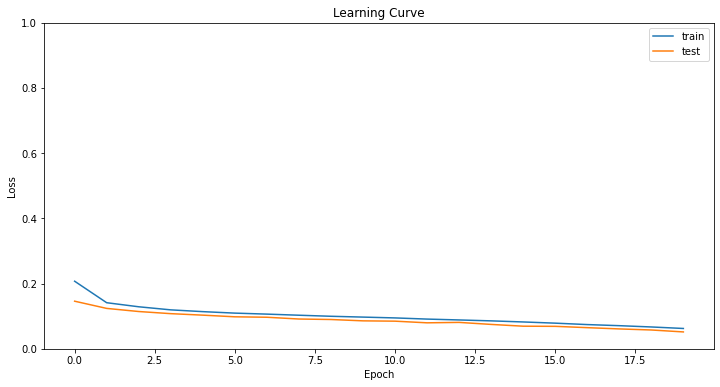

In [49]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

In [50]:
final_pred = []

for i in tqdm(range(pred.shape[0]), miniters=1000):
    a = pred.loc[[i]]
    a = a.apply(lambda x:x>0.2, axis =1)
    a = a.transpose()
    a = a.loc[a[i]==True]
    ' '.join(list(a.index))
    final_pred.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [02:24<00:00, 423.78it/s]


In [60]:
gc.collect()

750

In [51]:
sample_sub['tags'] = final_pred

In [52]:
sample_sub.to_csv('My_Final_Result.csv', index = False)

In [ ]:
My_result